In [1]:
from adjustText import adjust_text
from google.cloud import spanner
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spanner_client = spanner.Client()
instance = spanner_client.instance('ml-models-characterization-db')
database = instance.database('models_db')

In [3]:
num_models = dict()
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, COUNT(model_name) as count'
        ' FROM Models'
        ' WHERE model_type = "canonical"'
        ' GROUP BY sub_category'
    )
    
for row in results:
    num_models[row[0]] = row[1]
    
print(num_models)

{'TextClassification': 2, 'ImageGeneration': 5, 'ImageSegmentation': 7, 'VideoClassification': 1, 'PalmDetection': 1, 'ImageObjectDetection': 16, 'AutomaticSpeechRecognition': 1, 'FaceDetection': 2, 'ImageStyleTransfer': 2, 'TextLanguageModel': 1, 'ImageAugmentation': 1, 'AudioPitchExtraction': 1, 'VideoGeneration': 2, 'ImageRNNAgent': 1, 'EmotionRecognition': 1, 'AudioEmbedding': 2, 'ImageSuperResolution': 2, 'TextGeneration': 3, 'ImagePoseDetection': 1, 'TextRetrievalQuestionAnswering': 3, 'TextEmbedding': 12, 'ImageOthers': 1, 'VideoText': 1, 'ImageFeatureVector': 7, 'ImageClassification': 27}


In [4]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type)'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE model_type = "canonical"'
        ' GROUP BY model_name'
        ' ORDER BY model_name'
    )
    
total_ops = dict()
for row in results:
    total_ops[row[0]] = row[1]
    
print(total_ops)

{'LAReQA_mBERT_En_En_1': 3019, 'LaBSE_1': 6901, 'ResNet101-DUC': 1000, 'Wiki-words-250_2': 44, 'albert_lite_base_squadv1_1': 2682, 'bigbigan-resnet50_1': 1590, 'biggan-128_2': 212, 'biggan-deep-128_1': 586, 'bvlcalexnet': 74, 'caffenet': 68, 'compare_gan_model_15_cifar10_resnet_cifar_1': 2892, 'context_rcnn_resnet101_snapshot_serengeti_2020_06_10': 2204, 'cord-19_swivel-128d_3': 76, 'deeplabv3_1_default_1': 72, 'deepspeech-0.7.4': 232, 'delf_1': 491, 'densenet': 251, 'distilbert-base-uncased-distilled-squad-384': 1294, 'distilgpt2-64': 1102, 'efficientnet_b5_feature-vector_1': 1791, 'efficientnet_b6_feature-vector_1': 2079, 'efficientnet_b7_feature-vector_1': 2549, 'electra-small-finetuned-imdb': 1527, 'elmo_3': 591, 'emotion-ferplus': 94, 'esrgan-tf2_1': 1773, 'fast_neural_style_transfer': 299, 'faster_rcnn_nas_coco_2018_01_28': 7334, 'faster_rcnn_openimages_v4_inception_resnet_v2_1': 39821, 'ganeval-cifar10-convnet_1': 187, 'googlenet': 475, 'gpt2-64': 2188, 'i3d-kinetics-400_1': 256

In [5]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type = "Conv2D" and model_type = "canonical"'
        ' GROUP BY model_name'
        ' ORDER BY count DESC;'
    )
    
conv2d_ops_percent = dict()
for row in results:
    conv2d_ops_percent[row[0]] = row[1] / total_ops[row[0]]

conv2d_ops_percent = {key: value for key, value in 
                      sorted(conv2d_ops_percent.items(), 
                             key=lambda item: item[1], reverse = False)}
    
print(conv2d_ops_percent)

{'mil-nce_s3d_1': 0.001658374792703151, 'faster_rcnn_openimages_v4_inception_resnet_v2_1': 0.006202757339092439, 'openimages_v4_ssd_mobilenet_v2_1': 0.007517769272826681, 'mask_rcnn_resnet50_atrous_coco_2018_01_28': 0.010623766884200941, 'elmo_3': 0.011844331641285956, 'universal-sentence-encoder-lite_2': 0.012861736334405145, 'mask_rcnn_inception_v2_coco_2018_01_28': 0.014334155363748458, 'rfcn_resnet101_coco_2018_01_28': 0.016383675901102176, 'tweening_conv3d_bair_1': 0.031180400890868598, 'compare_gan_model_15_cifar10_resnet_cifar_1': 0.0318118948824343, 'lite-model_spice_1': 0.03594771241830065, 'faster_rcnn_nas_coco_2018_01_28': 0.03695118625579493, 'context_rcnn_resnet101_snapshot_serengeti_2020_06_10': 0.048548094373865695, 'fast_neural_style_transfer': 0.05351170568561873, 'bigbigan-resnet50_1': 0.05911949685534591, 'speech_embedding_1': 0.06289308176100629, 'zfnet512': 0.07142857142857142, 'nonsemantic-speech-benchmark_trill_1': 0.07614942528735633, 'biggan-deep-128_1': 0.0767

In [6]:
labels = list(conv2d_ops_percent.keys())
values = list()
for label in labels:
    if label not in conv2d_ops_percent:
        values.append(0)
        continue
    values.append(conv2d_ops_percent[label] * 100)

labels = labels[:-len(labels) + 20]
values = values[:-len(values) + 20]

print(labels)
print(values)

['mil-nce_s3d_1', 'faster_rcnn_openimages_v4_inception_resnet_v2_1', 'openimages_v4_ssd_mobilenet_v2_1', 'mask_rcnn_resnet50_atrous_coco_2018_01_28', 'elmo_3', 'universal-sentence-encoder-lite_2', 'mask_rcnn_inception_v2_coco_2018_01_28', 'rfcn_resnet101_coco_2018_01_28', 'tweening_conv3d_bair_1', 'compare_gan_model_15_cifar10_resnet_cifar_1', 'lite-model_spice_1', 'faster_rcnn_nas_coco_2018_01_28', 'context_rcnn_resnet101_snapshot_serengeti_2020_06_10', 'fast_neural_style_transfer', 'bigbigan-resnet50_1', 'speech_embedding_1', 'zfnet512', 'nonsemantic-speech-benchmark_trill_1', 'biggan-deep-128_1', 'videoflow_encoder_1']
[0.16583747927031509, 0.6202757339092438, 0.7517769272826681, 1.0623766884200943, 1.1844331641285957, 1.2861736334405145, 1.4334155363748458, 1.6383675901102175, 3.11804008908686, 3.18118948824343, 3.594771241830065, 3.695118625579493, 4.854809437386569, 5.351170568561873, 5.911949685534592, 6.289308176100629, 7.142857142857142, 7.614942528735632, 7.679180887372014, 8

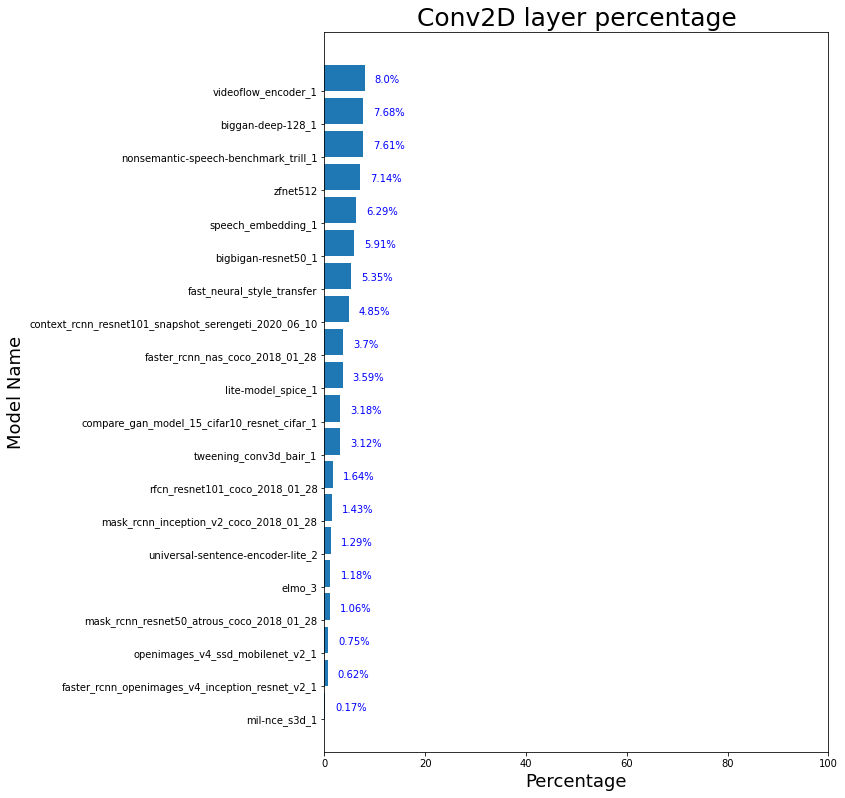

['mil-nce_s3d_1', 'faster_rcnn_openimages_v4_inception_resnet_v2_1', 'openimages_v4_ssd_mobilenet_v2_1', 'mask_rcnn_resnet50_atrous_coco_2018_01_28', 'elmo_3', 'universal-sentence-encoder-lite_2', 'mask_rcnn_inception_v2_coco_2018_01_28', 'rfcn_resnet101_coco_2018_01_28', 'tweening_conv3d_bair_1', 'compare_gan_model_15_cifar10_resnet_cifar_1', 'lite-model_spice_1', 'faster_rcnn_nas_coco_2018_01_28', 'context_rcnn_resnet101_snapshot_serengeti_2020_06_10', 'fast_neural_style_transfer', 'bigbigan-resnet50_1', 'speech_embedding_1', 'zfnet512', 'nonsemantic-speech-benchmark_trill_1', 'biggan-deep-128_1', 'videoflow_encoder_1']


In [7]:
fig = plt.figure(figsize = (7,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Conv2D layer percentage", fontsize = 25)
ax.set_xlim([0, 100])
plt.barh(labels, values, align='edge')
ax.set_xlabel('Percentage', fontsize = 18)
ax.set_ylabel('Model Name', fontsize = 18)

for index, value in enumerate(values):
    ax.text(value + 2, index + .25, str(round(value,2)) + "%", color='blue')

plt.show()

print(labels)

In [8]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Placeholder", "Input_Placeholder")'
        ' AND model_type = "canonical" and source = "TFLite"'
        ' GROUP BY sub_category, operator_type'
        ' ORDER BY sub_category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

print(category_op_dist['ImageClassification'])
print(category_op_dist['TextEmbedding'])
print(category_total_ops)

{'Conv2D': 1351, 'DepthwiseConv2dNative': 443, 'Add': 396, 'Relu': 266, 'Concat': 204, 'AvgPool': 165, 'Mul': 122, 'MaxPool': 53, 'Split': 38, 'HardSwish': 21, 'Mean': 14, 'Pad': 12, 'Reshape': 9, 'Softmax': 8, 'FULLY_CONNECTED': 8, 'StridedSlice': 8, 'Gather': 2, 'Squeeze': 2, 'Pow': 2, 'Prod': 2, 'Maximum': 1, 'Shape': 1, 'Cast': 1, 'Transpose': 1, 'L2_NORMALIZATION': 1, 'Dequantize': 1, 'Pack': 1, 'QUANTIZE': 1}
{'Reshape': 1406, 'Slice': 1010, 'FULLY_CONNECTED': 941, 'Transpose': 663, 'Add': 500, 'Mul': 330, 'Pack': 146, 'Sub': 50, 'Mean': 50, 'Softmax': 36, 'SquaredDifference': 25, 'Rsqrt': 25, 'Tanh': 12, 'Pow': 12, 'Gather': 4, 'Unpack': 2, 'Cast': 2, 'StridedSlice': 2, 'Pad': 2, 'Concat': 1}
{'AudioPitchExtraction': 303, 'AutomaticSpeechRecognition': 224, 'FaceDetection': 234, 'ImageClassification': 3134, 'ImageObjectDetection': 772, 'ImagePoseDetection': 33, 'ImageSegmentation': 993, 'ImageStyleTransfer': 64, 'PalmDetection': 193, 'TextClassification': 3048, 'TextEmbedding': 5

sum 3134


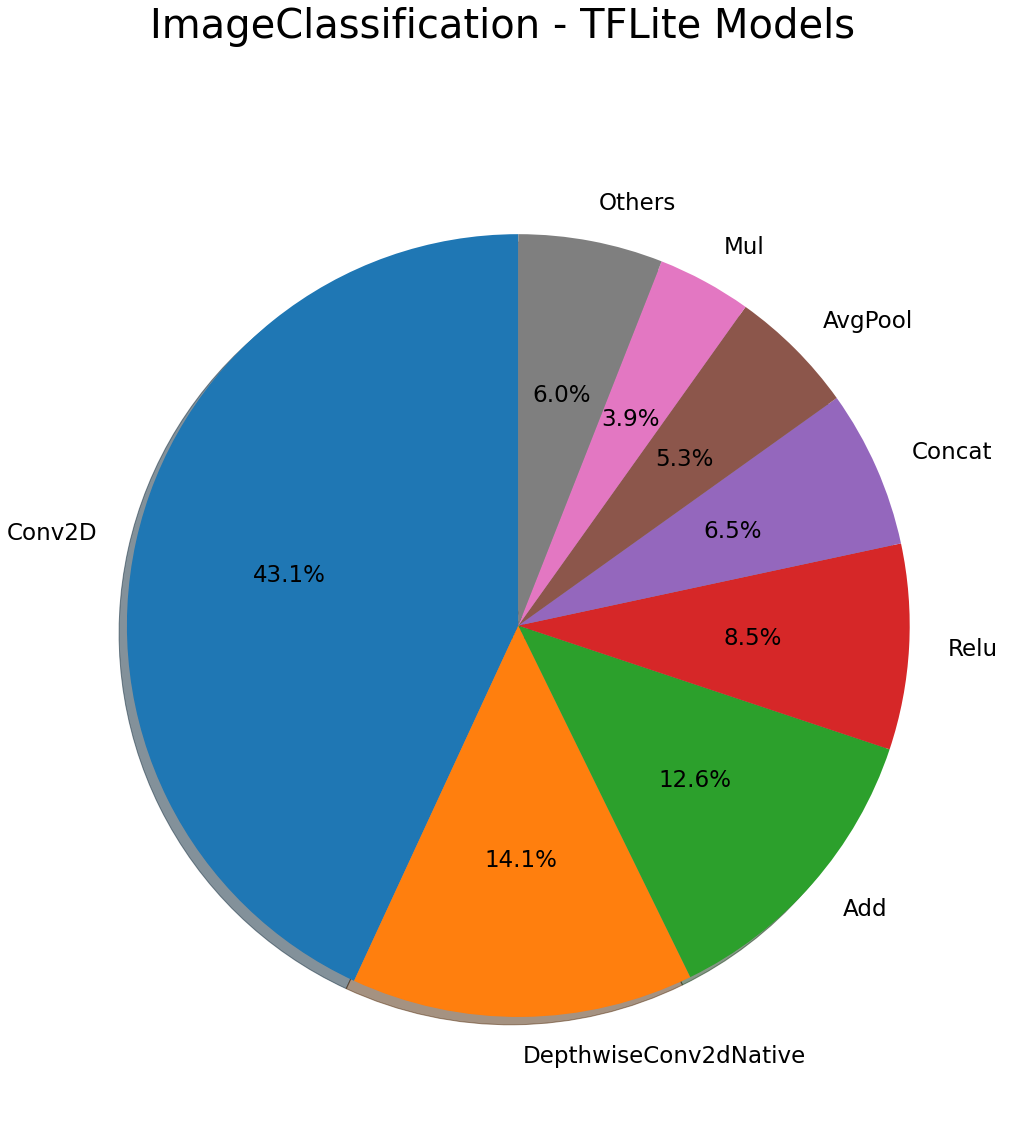

sum 772


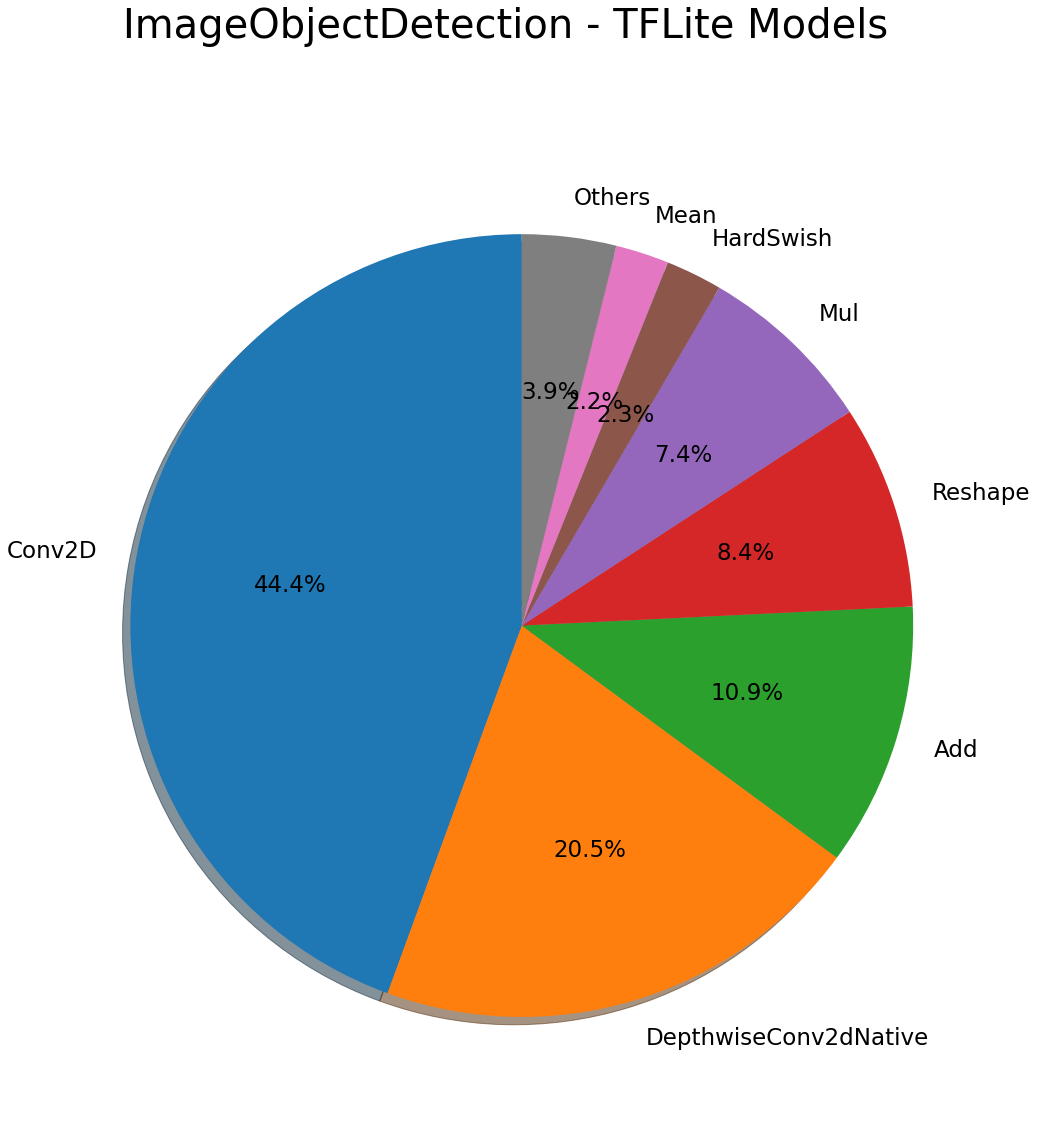

sum 993


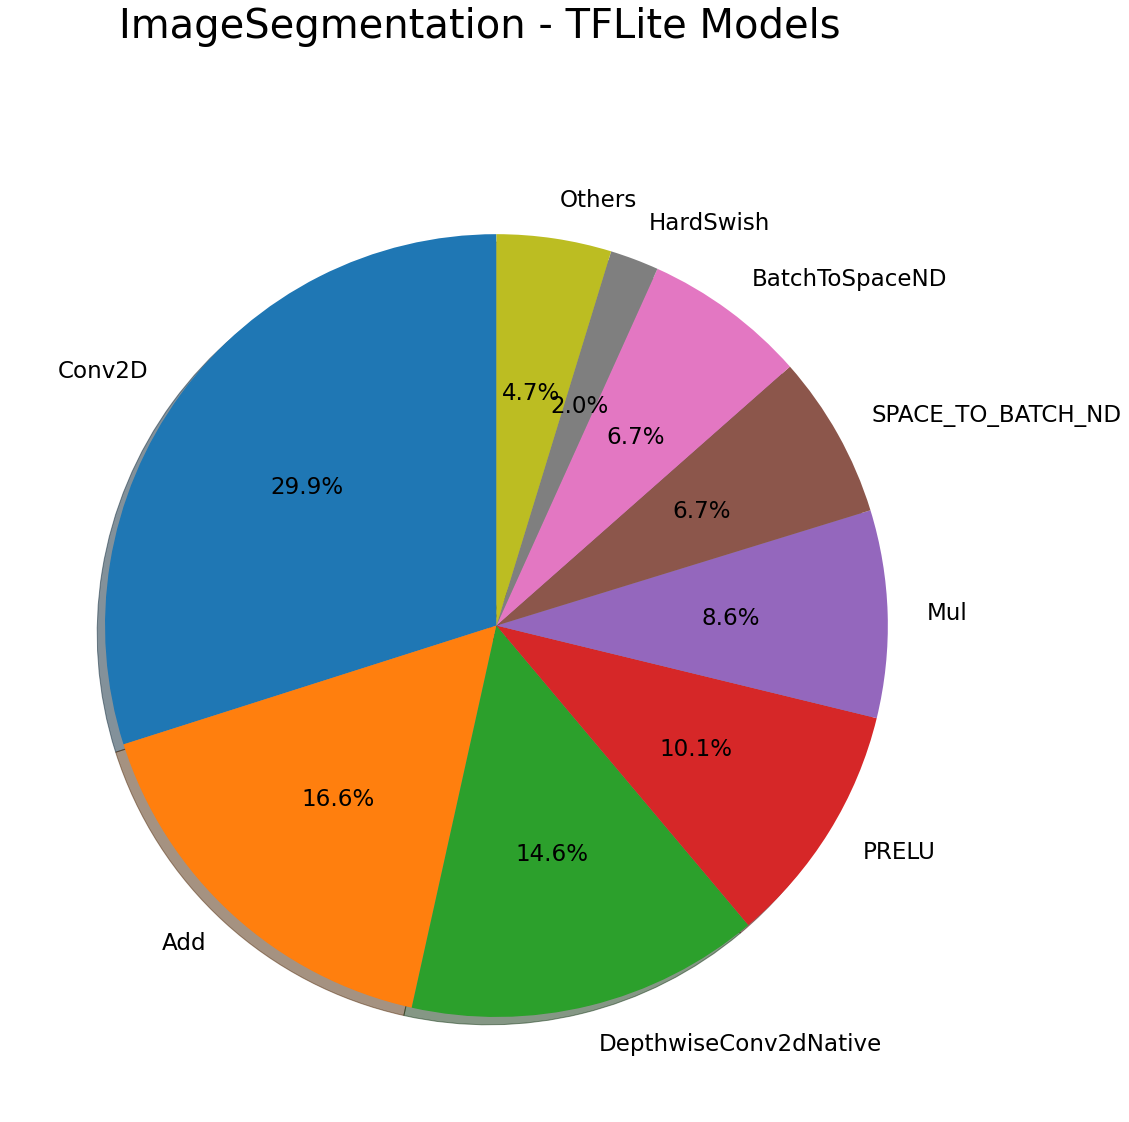

sum 5219


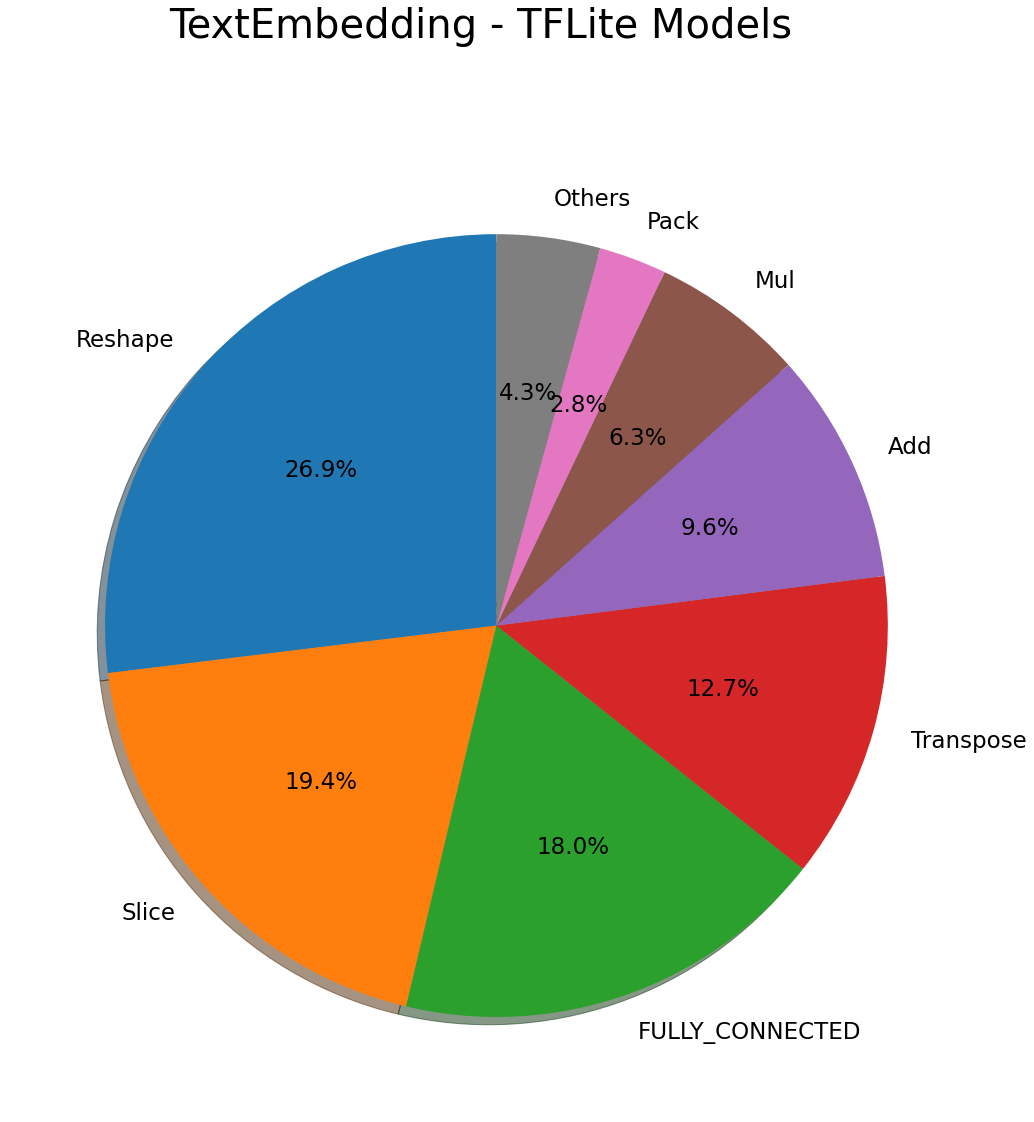

sum 3274


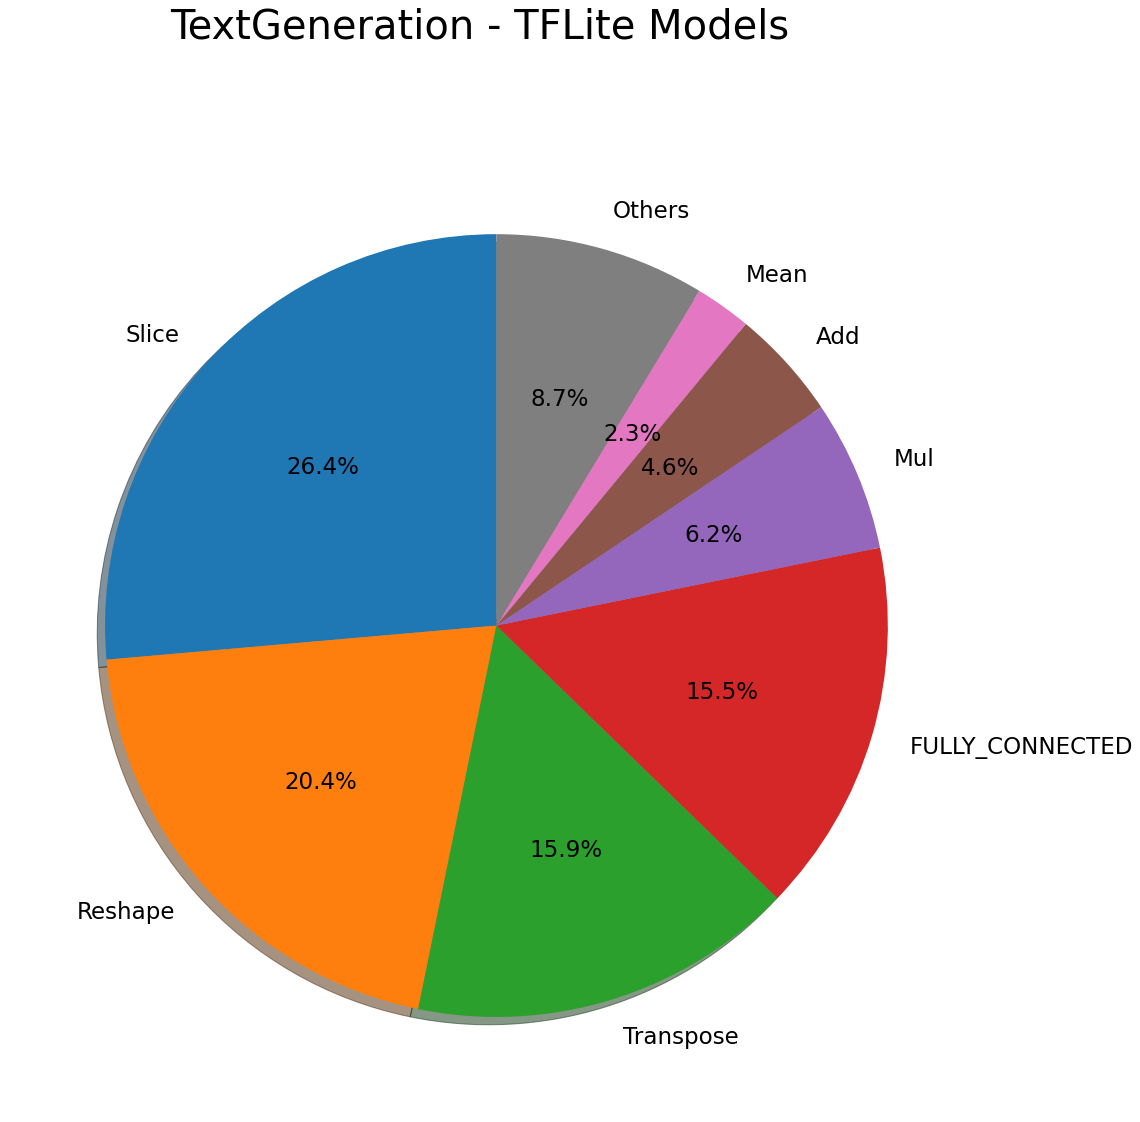

sum 2825


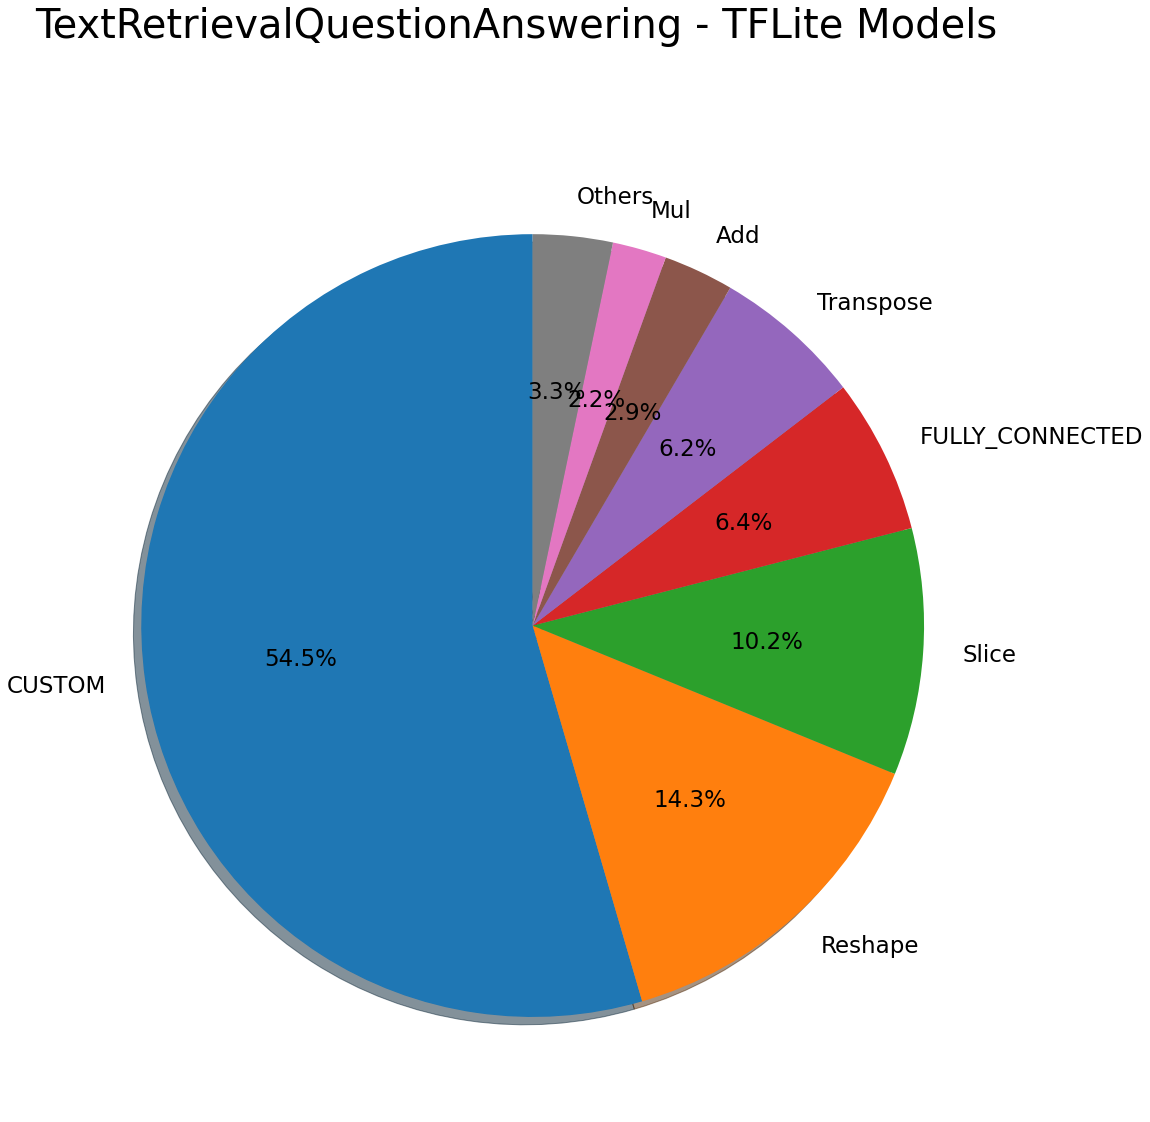

In [9]:
for category in categories:
    if(num_models[category] >= 3):
        labels = list(category_op_dist[category].keys())
        values = list(category_op_dist[category].values())

        sum_values = sum(values)
        print("sum" , sum_values)

        cumm_val = 0
        for index in reversed(range(len(labels))):
            if values[index] / sum_values > 0.02:
                break

            cumm_val += values[index]
            values.pop(index)
            labels.pop(index)


        if cumm_val != 0:
            labels.append("Others")
            values.append(cumm_val)

        fig, ax = plt.subplots(figsize = (18, 18))

        ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 23})
        fig.suptitle(category + " - TFLite Models", fontsize = '40')
        plt.show()

In [10]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Placeholder", "Input_Placeholder")'
        ' AND model_type = "canonical" and source = "TF"'
        ' GROUP BY sub_category, operator_type'
        ' ORDER BY sub_category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

print(category_op_dist['ImageClassification'])
print(category_op_dist['TextEmbedding'])
print(category_total_ops)

{'Conv2D': 7460, 'Transpose': 502, 'Relu': 399, 'Add': 358, 'Mul': 295, 'Split': 200, 'Identity': 132, 'ConcatV2': 119, 'FusedBatchNorm': 97, 'Reshape': 96, 'Pad': 89, 'Mean': 79, 'AddV2': 56, 'Softplus': 37, 'Pow': 37, 'BiasAdd': 36, 'MaxPool': 30, 'MatMul': 24, 'AvgPool': 23, 'Assert': 17, 'Concat': 15, 'PyFunc': 14, 'SplitV': 13, 'AddN': 13, 'Shape': 11, 'LRN': 10, 'Sub': 8, 'GreaterEqual': 8, 'Softmax': 7, 'Enter': 5, 'Maximum': 4, 'FloorDiv': 4, 'Greater': 4, 'Squeeze': 4, 'Unpack': 4, 'Less': 4, 'StridedSlice': 4, 'All': 3, 'Minimum': 3, 'Pack': 3, 'Equal': 2, 'NextIteration': 2, 'Cast': 2, 'ExpandDims': 2, 'Merge': 2, 'Range': 2, 'TensorArrayV3': 2, 'Switch': 2, 'Neg': 2, 'Exit': 2, 'DecodeJpeg': 1, 'TensorArrayScatterV3': 1, 'LoopCond': 1, 'Dilation2D': 1, 'TensorArrayReadV3': 1, 'TensorArraySizeV3': 1, 'LookupTableFindV2': 1, 'TensorArrayWriteV3': 1, 'ParseExample': 1, 'Slice': 1, 'ResizeBilinear': 1, 'PadV2': 1, 'TensorArrayGatherV3': 1, 'TopKV2': 1}
{'Mul': 2013, 'AddV2': 18

sum 10261


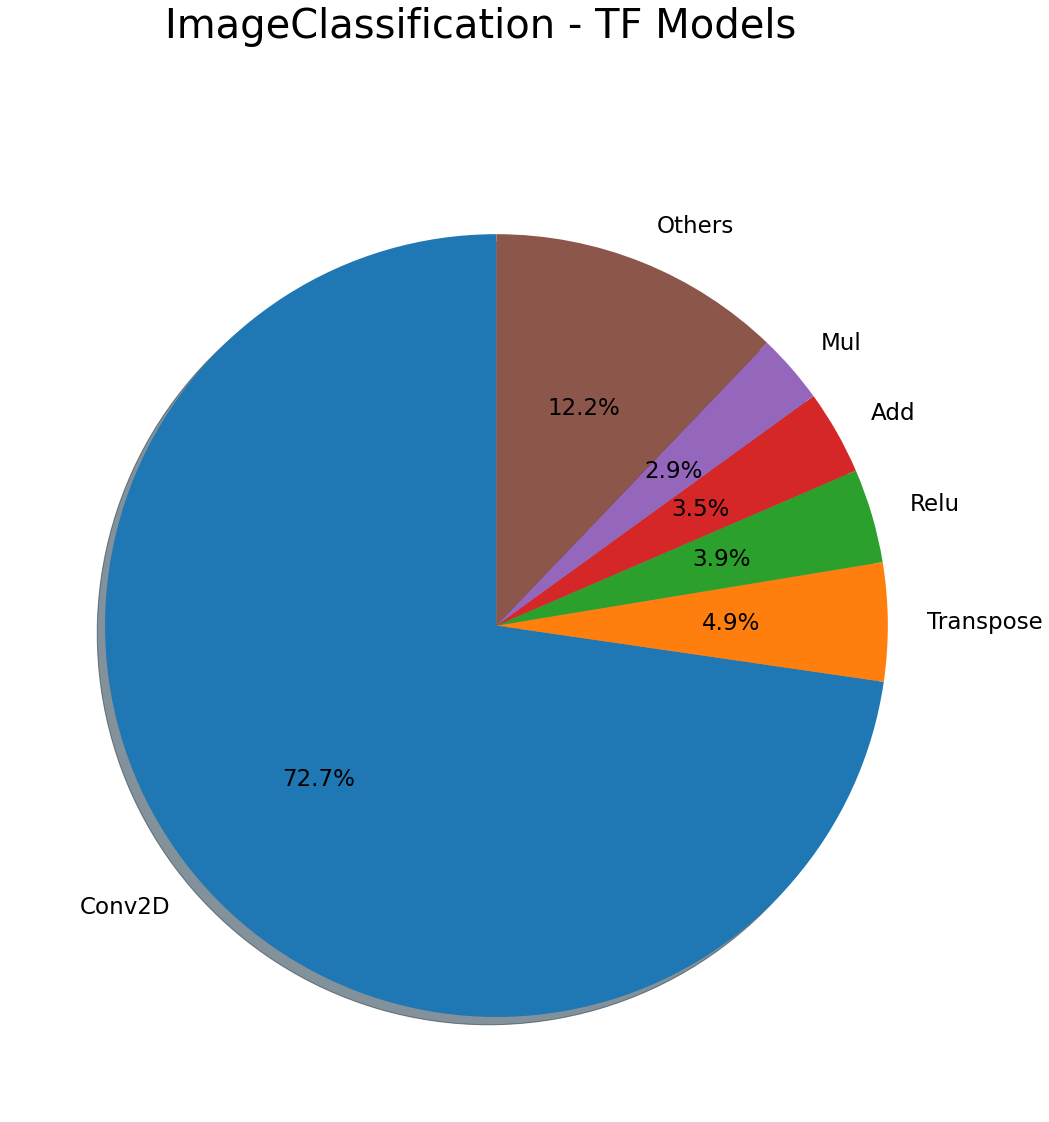

sum 8903


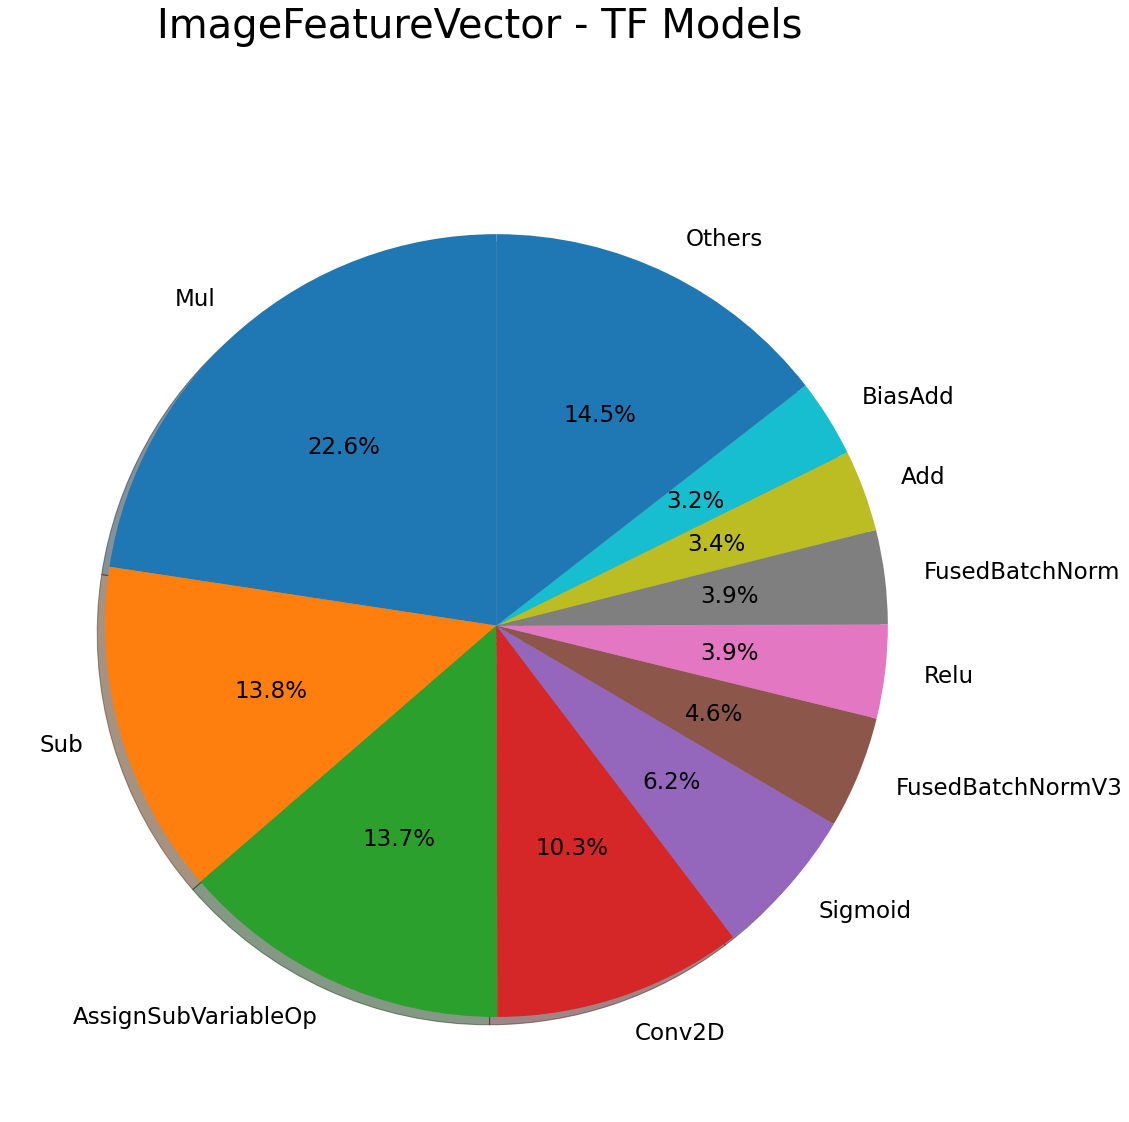

sum 5413


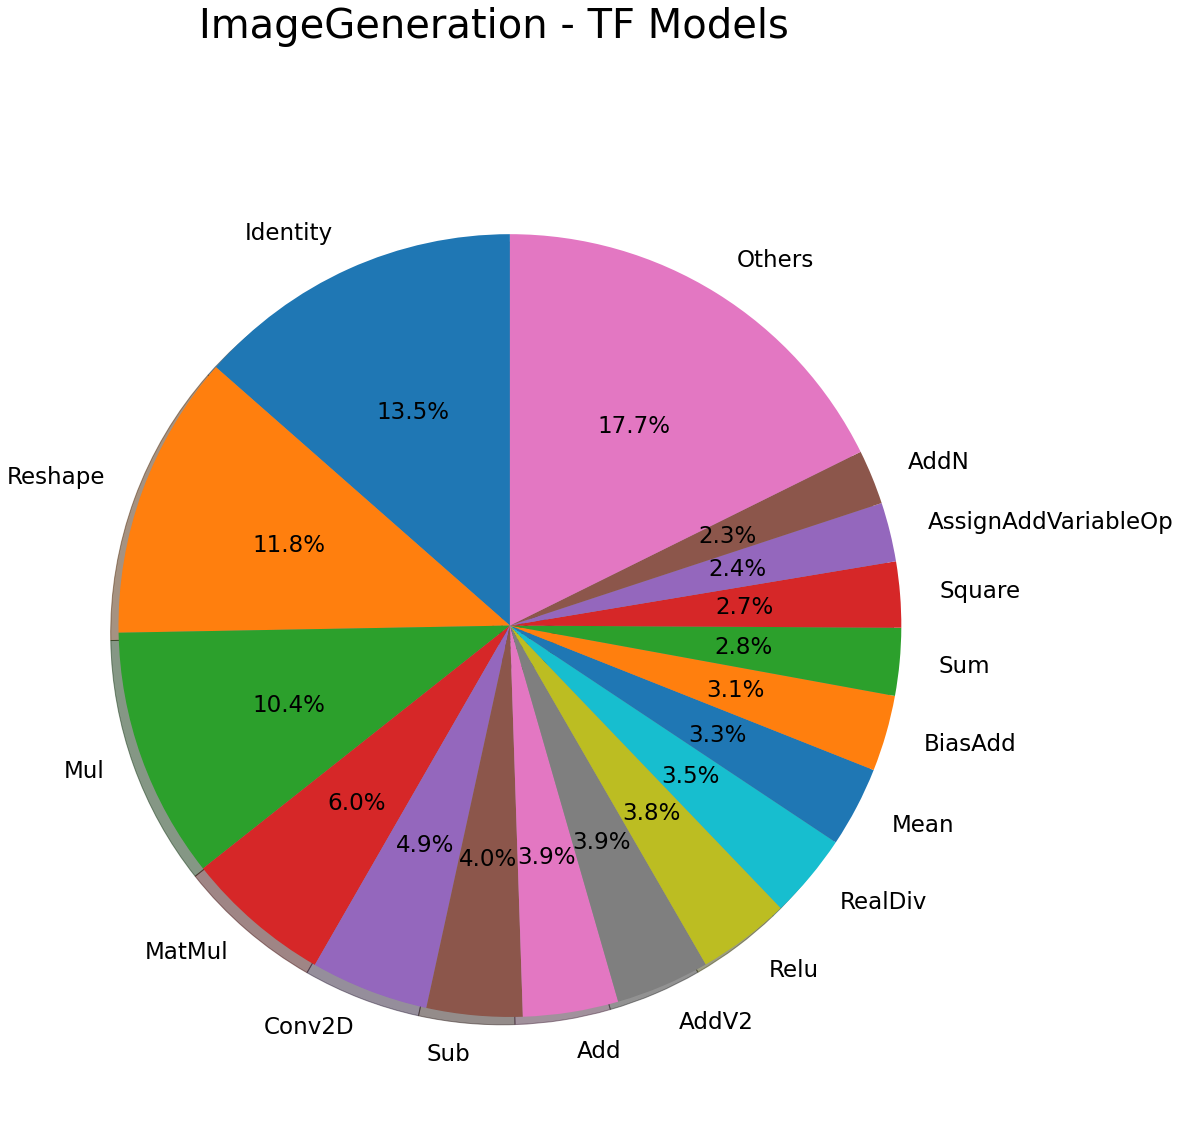

sum 78101


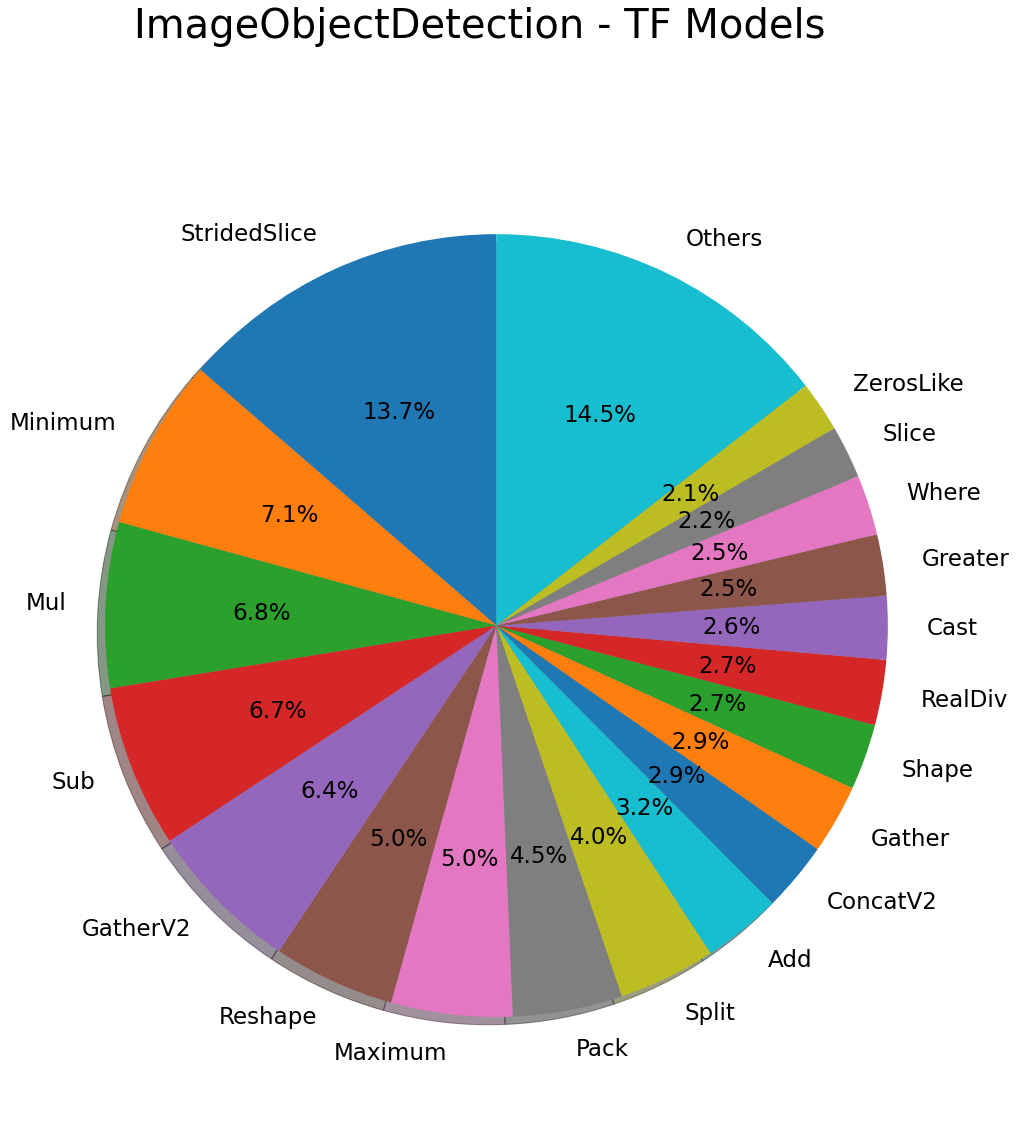

sum 1106


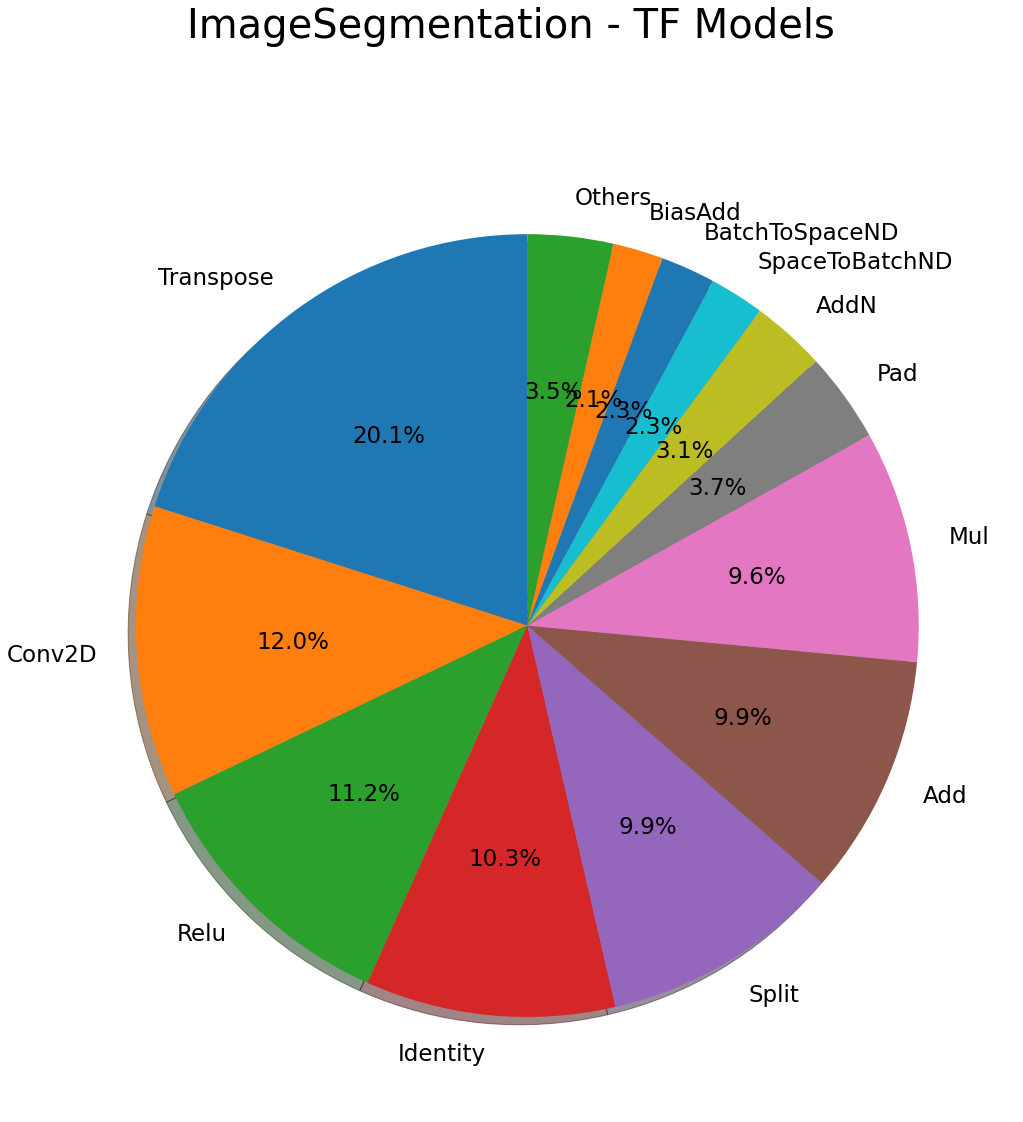

sum 12064


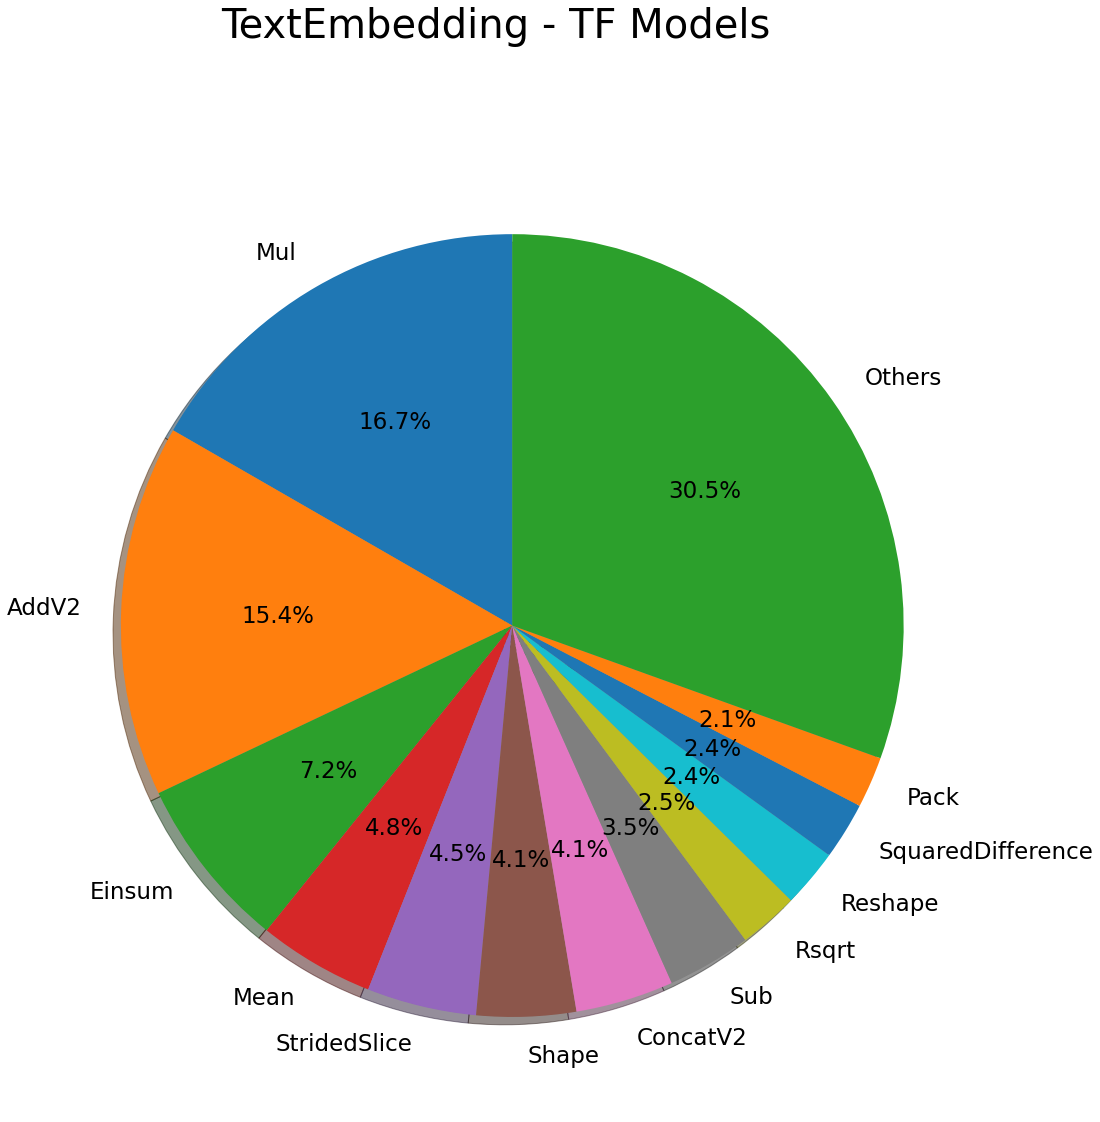

sum 3016


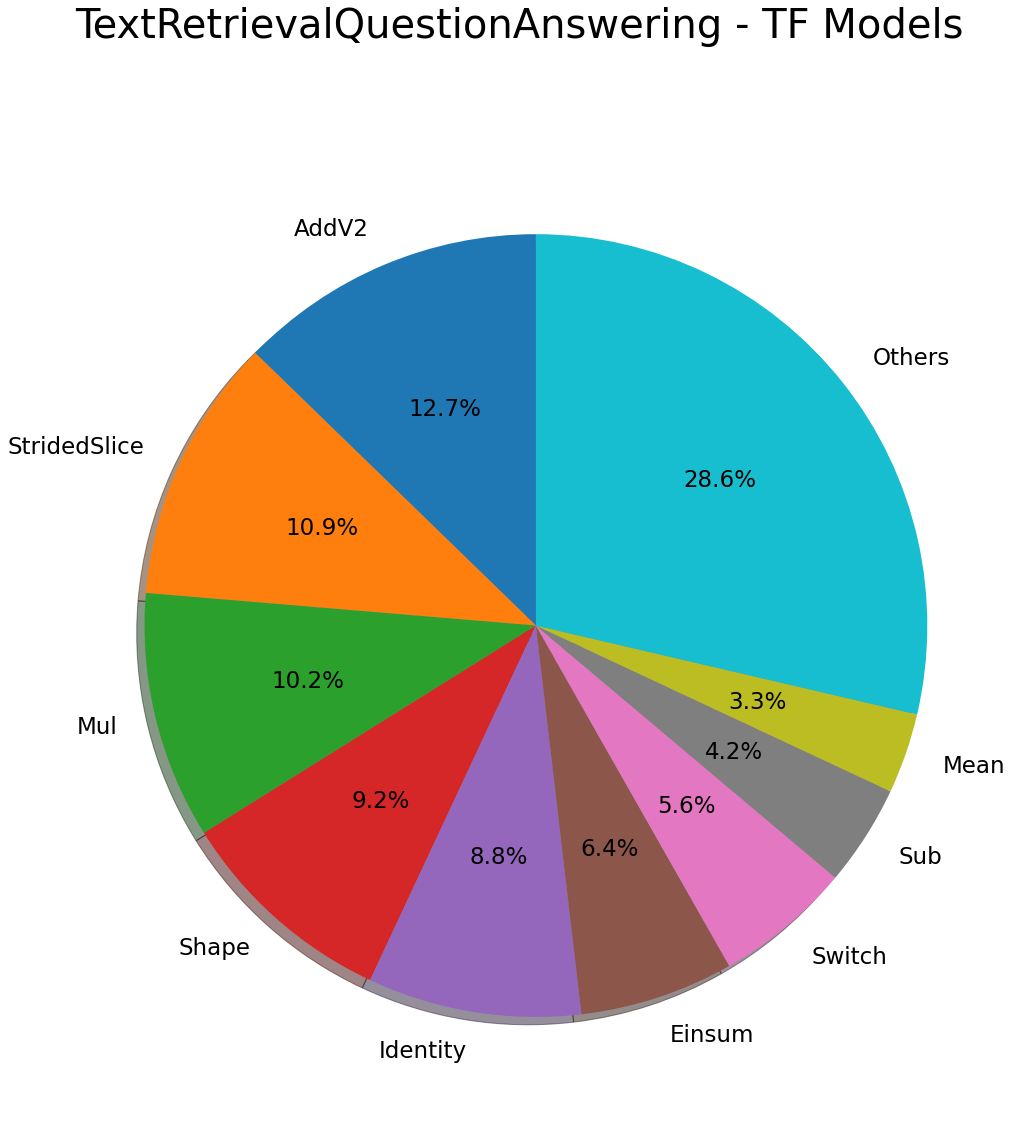

In [11]:
for category in categories:
    if(num_models[category] >= 3):
        labels = list(category_op_dist[category].keys())
        values = list(category_op_dist[category].values())

        sum_values = sum(values)
        print("sum" , sum_values)

        cumm_val = 0
        for index in reversed(range(len(labels))):
            if values[index] / sum_values > 0.02:
                break

            cumm_val += values[index]
            values.pop(index)
            labels.pop(index)


        if cumm_val != 0:
            labels.append("Others")
            values.append(cumm_val)

        fig, ax = plt.subplots(figsize = (18, 18))

        ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 23})
        fig.suptitle(category + " - TF Models", fontsize = '40')
        plt.show()

In [12]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, padding, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Input_Placeholder")'
        ' AND padding IS NOT NULL and model_type = "canonical"'
        ' GROUP BY operator_type, padding'
        ' ORDER BY operator_type, count DESC;'
    )

In [13]:
operation_padding = dict()

for row in results:
    if row[0] not in operation_padding:
        operation_padding[row[0]] = dict()
        operation_padding[row[0]]['SAME'] = 0
        operation_padding[row[0]]['VALID'] = 0

    operation_padding[row[0]][row[1]] = row[2]
    

labels = list(operation_padding.keys())
same_pad_values = list()
valid_pad_values = list()

for label in labels:
    same_num = operation_padding[label]['SAME']
    valid_num = operation_padding[label]['VALID']
    total = same_num + valid_num
    same_pad_values.append(round((same_num / total) *  100))
    valid_pad_values.append(round((valid_num / total) * 100))

print(labels)
print(same_pad_values)
print(valid_pad_values)

['AvgPool', 'Conv2D', 'Conv2DBackpropInput', 'DepthwiseConv2dNative', 'MaxPool']
[81, 32, 100, 93, 53]
[19, 68, 0, 7, 47]


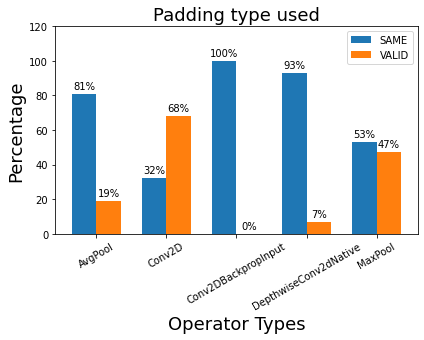

In [14]:
fig, ax = plt.subplots()

x = np.arange(len(labels))  # the label locations
width = 0.35
rects1 = ax.bar(x - width/2, same_pad_values, width, label='SAME')
rects2 = ax.bar(x + width/2, valid_pad_values, width, label='VALID')

ax.set_ylabel('Percentage', fontsize = 18)
ax.set_xlabel('Operator Types', fontsize = 18)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title("Padding type used", fontsize = 18)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height) + "%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=30)

ax.set_ylim([0, 120])

plt.show()


In [15]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT activation_function, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE activation_function IS NOT NULL AND activation_function != "NONE"'
        ' AND model_type = "canonical"'
        ' GROUP BY activation_function'
        ' ORDER BY count DESC;'
    )

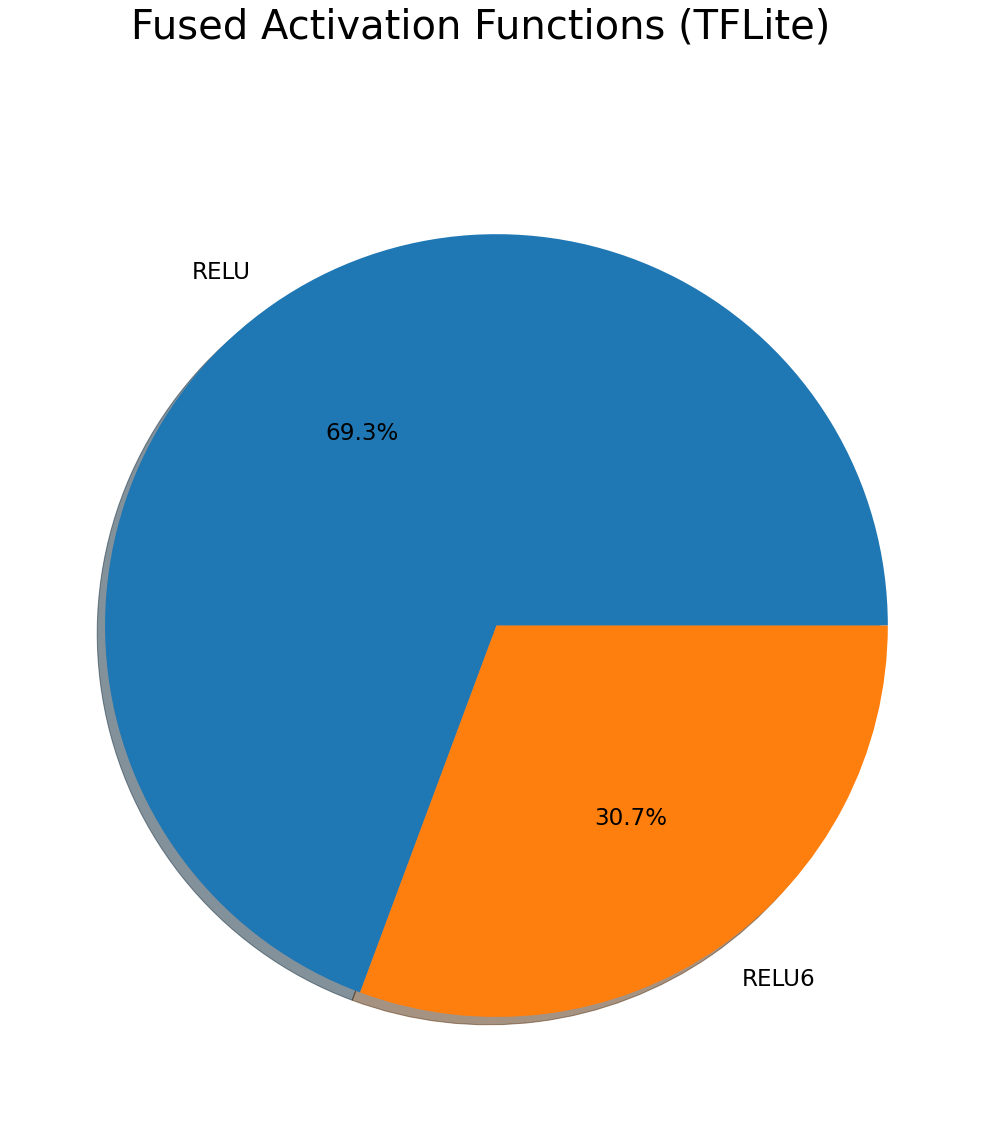

In [16]:
fused_activation_count = dict()
total_count = 0

for row in results:
    fused_activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(fused_activation_count.keys())
values = list(fused_activation_count.values())

fig, ax = plt.subplots(figsize = (18, 18))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Fused Activation Functions (TFLite)", fontsize = '40')
plt.show()

In [17]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, COUNT(operator_id) as count'
        ' FROM Operators JOIN Models'
        ' ON Operators.model_name = Models.model_name'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh", "Softmax")'
        ' AND model_type = "canonical"'
        ' GROUP BY operator_type'
        ' ORDER BY count DESC;'
    )

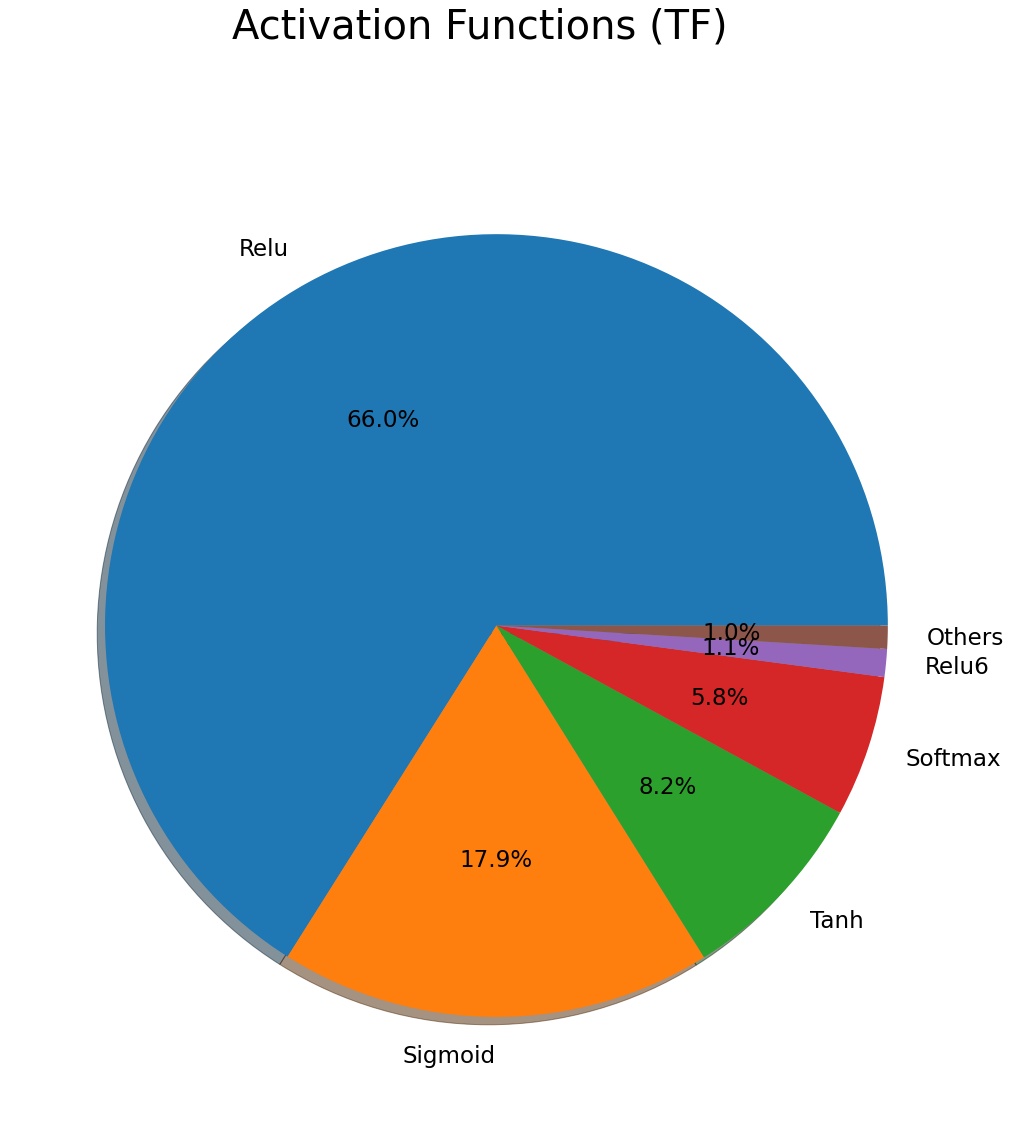

In [18]:
activation_count = dict()
total_count = 0

for row in results:
    activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(activation_count.keys())
values = list(activation_count.values())

others = 0

for index in reversed(range(len(values))):
    if values[index] / sum(values) <= 0.01 :
        others += values[index]
        values.pop(index)
        labels.pop(index)
        
values.append(others)
labels.append('Others')

fig, ax = plt.subplots(figsize = (18, 18))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Activation Functions (TF)", fontsize = '40')
plt.show()

In [19]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators ON Models.model_name = Operators.model_name'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh", "Softmax")'
        ' and model_type = "canonical"'
        ' GROUP BY category, operator_type'
        ' ORDER BY count DESC;'
    )

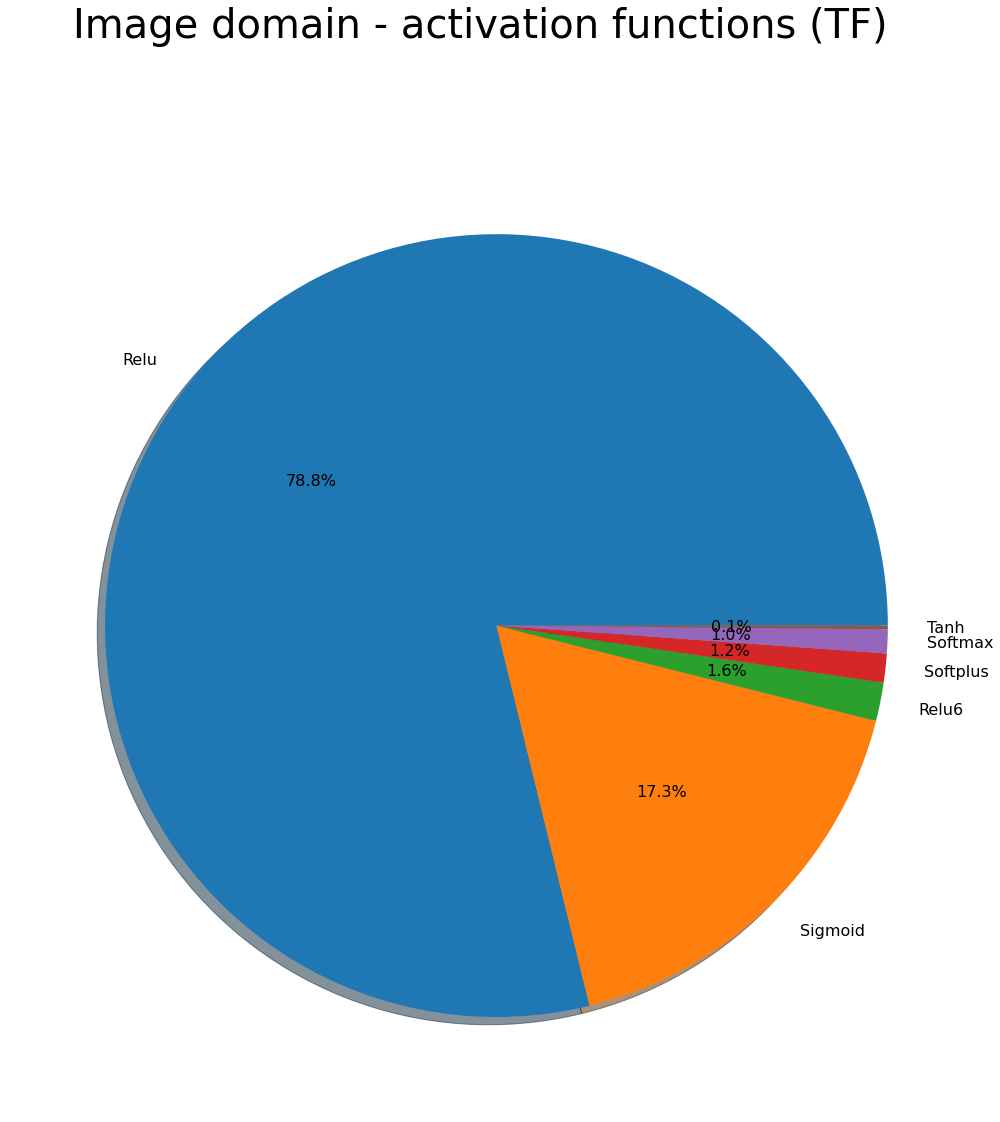

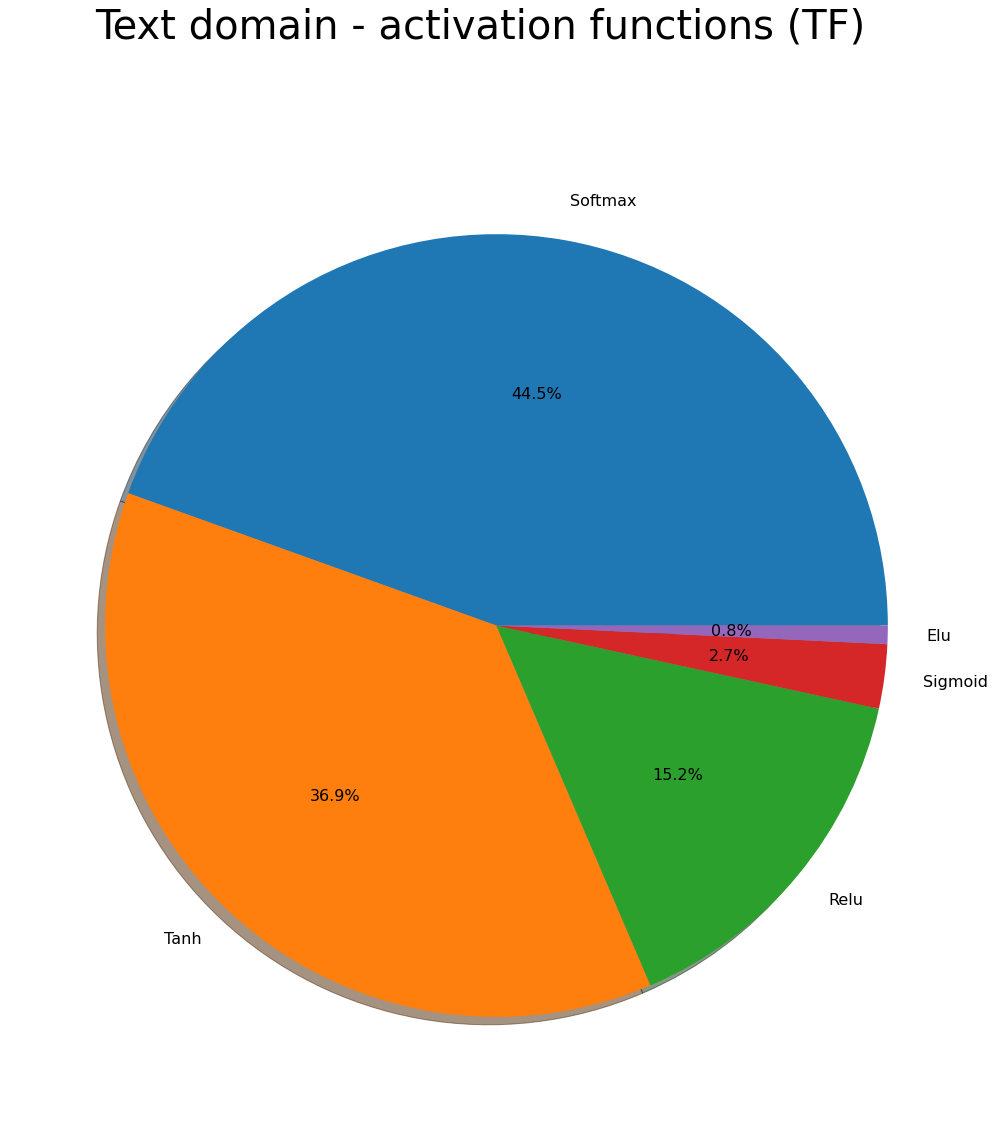

In [20]:
categories = list()
activation_data = dict()
activation_data.update({"Image" : dict()})
activation_data.update({"Text" : dict()})

for row in results:
    
    if "Image" in row[0] or row[0] == "ObjectDetection":
        if row[1] not in activation_data["Image"]:
            activation_data["Image"].update({row[1] : 0})
        activation_data["Image"][row[1]] += row[2]
    elif "Text" in row[0]:
        if row[1] not in activation_data["Text"]:
            activation_data["Text"].update({row[1] : 0})
        activation_data["Text"][row[1]] += row[2]

for key in activation_data.keys():
    
    labels = list(activation_data[key].keys())
    values = list(activation_data[key].values())
    
    fig, ax = plt.subplots(figsize = (18, 18))
    ax.pie(values, labels = labels,
           autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 16})
    fig.suptitle(key + " domain - activation functions (TF)", fontsize = '40')
    plt.show()

In [21]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT model_name, embeddings FROM Models WHERE embeddings IS NOT NULL'
    )
    
embeddings_data = dict()
for row in results:
    embeddings_data[row[0]] = row[1]

print(embeddings_data)

{'LAReQA_mBERT_En_En_1': [0.22397584, 1.3784091, -0.71376497, -0.7065044, -0.035541046, -1.0099458, 0.59111464, -0.15800649, -1.6035752, -0.2213087, -0.2934658, -0.061880194, -0.6443224, 1.208187, 0.5619706, 1.5255852, -0.013478496, -0.34400696, 0.71718436, 0.9105089, -0.13622446, 1.095011, 1.5903656, 0.05163902, -1.0846128, 0.2631004, 1.7614578, -0.91079384, 0.1470792, -1.4162656, -0.822655, 0.9225951, 2.0644019, -0.25286013, -1.2080268, 1.4252522, -2.5796416, 0.5373956, -0.6667656, 1.495239, 0.10633045, -0.29651946, -0.7574522, 1.80604, -2.0514557, 1.1689147, 0.29005828, -0.4124444, 0.5565719, -0.5656318, 1.701447, -0.09281308, 0.05032219, 2.508718, -1.2538872, 2.7461019, 1.0456637, -1.2659212, -1.2294331, -1.4583718, -2.0817273, 1.1338559, -0.98318744, 3.2941535, -0.22977583, 1.8870254, -2.7315855, -1.212534, 0.023166457, 2.0231664, -0.3022216, -0.638136, -1.4398252, -2.33067, -1.0618325, 0.9501763, 1.21874, -1.9842143, -0.8499675, 0.11190197, -0.9106188, -0.04342026, -1.4314715, 0.

In [22]:
labels = list(embeddings_data.keys())
embeddings = list(embeddings_data.values())

tsne_model = TSNE()
new_embeddings = tsne_model.fit_transform(embeddings)

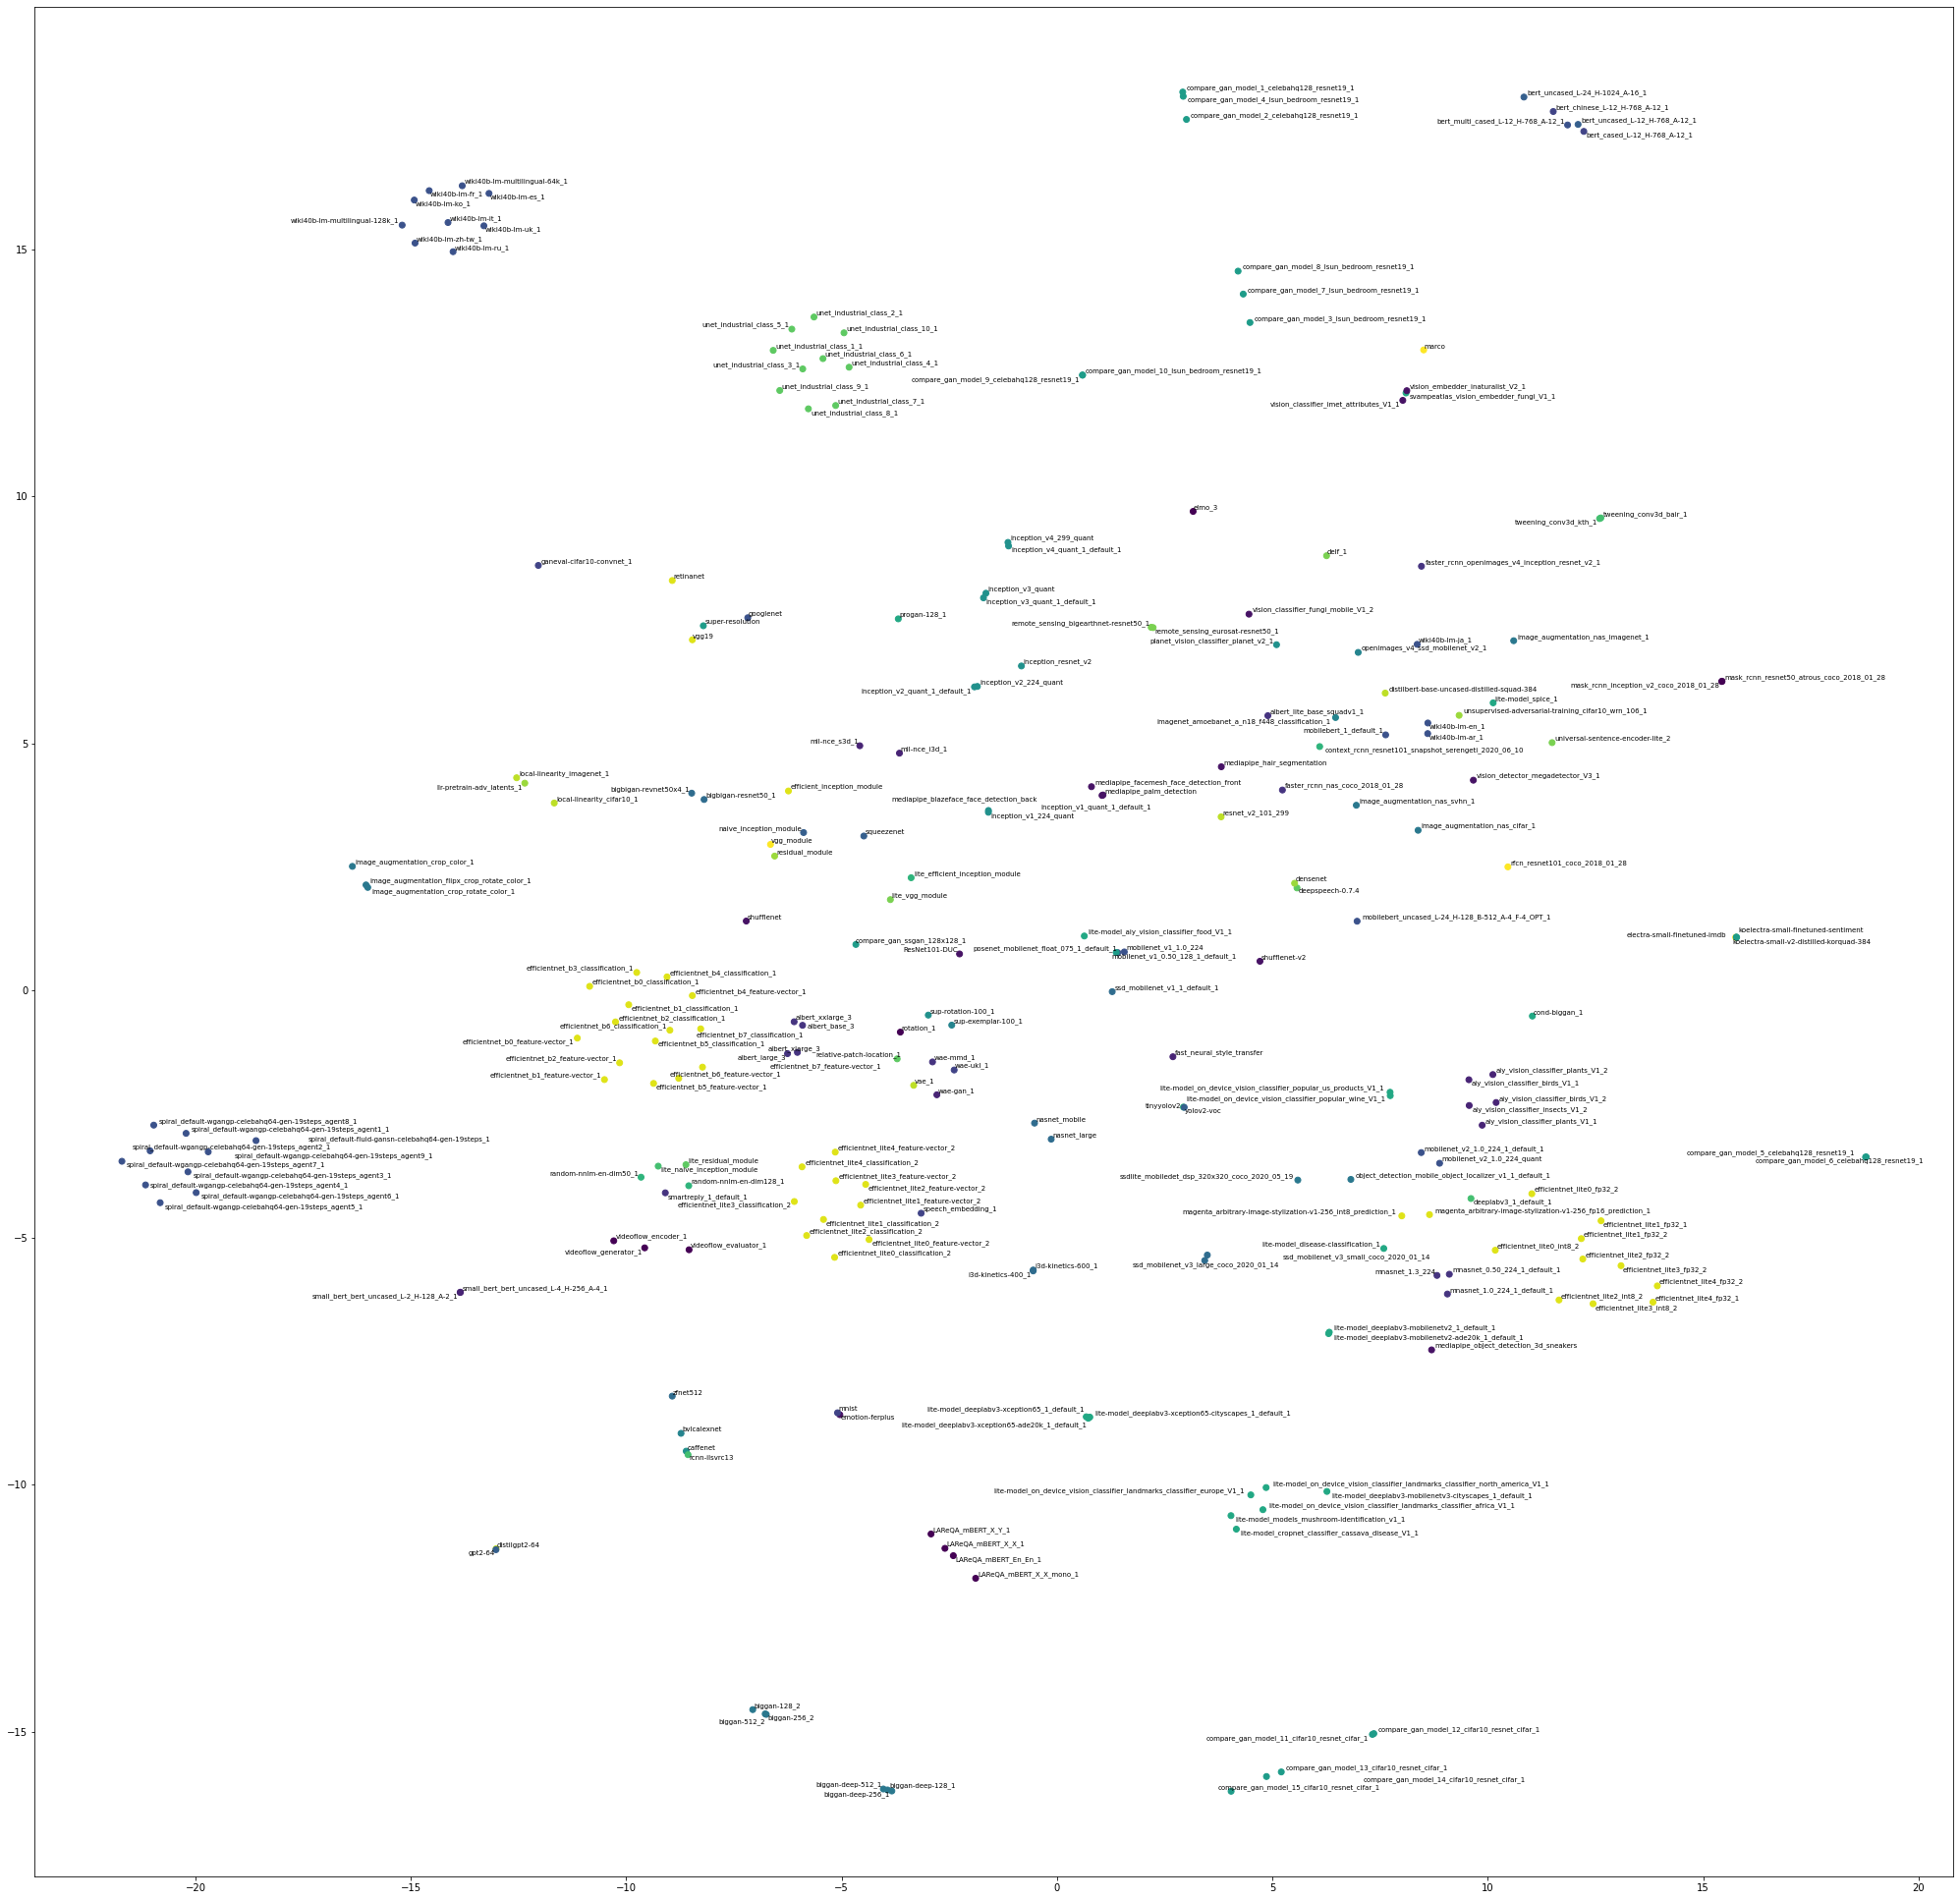

92


In [23]:
x = list()
y = list()

for embedding in new_embeddings:
    x.append(embedding[0])
    y.append(embedding[1])
    
colors = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48),
          (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212),
          (0, 128, 128), (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0),
          (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128),
          (0, 0, 0)]

distinct_model_names = set()

model_to_color = dict()
index = 0

colormap = list()

for label in labels:
    if label[:6] not in distinct_model_names:
        distinct_model_names.add(label[:6])
        model_to_color[label[:6]] = index
        index += 1
        index %= len(colors)
        
    colormap.append(model_to_color[label[:6]])
    
fig, ax = plt.subplots(figsize = (35, 35))
plt.scatter(x, y, c = colormap)

num_labels = range(len(labels))

texts = [plt.text(x[i], y[i], labels[i], fontsize = 7) for i in range(len(x))]
adjust_text(texts)

# x = 27
# index = 0
# while index < len(labels):
#     y = 20
#     for iterator in range(40):
#         if index >= len(labels):
#             break
            
#         plt.text(x, y, str(num_labels[index]) + " : " + labels[index], fontsize = 12)
#         y -= 1
#         index += 1
#     x += 10
    
plt.savefig("/home/shobhitbehl/plot.png")
plt.show()
print(len(distinct_model_names))